In [17]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import median_filter
from sklearn.model_selection import train_test_split
import warnings
import logging
from tqdm import tqdm
from keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, concatenate, Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Conv1D, Activation, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

seed = 42
np.random.seed(seed)

training_labels = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe": 4,
    "Time": 5,
    "Brain": 6,
    "Echoes": 7,
    "Wearing": 8,
    "Sorrow": 9,
    "Hey": 10,
    "Shine": 11,
}
data = np.load("../../data/x_train.npy")
target = np.load("../../data/y_train.npy")
#SHUFFLE DATA
p = np.random.permutation(data.shape[0])
data = data[p]
target = target[p]

test_split = 0.2
val_split = 0.1
#OneHotEncoding
target = tfk.utils.to_categorical(target)

#Split Train Test
x_train,x_test,y_train,y_test = train_test_split(data,target, test_size=test_split,random_state=42,stratify=target)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=val_split,random_state=42,stratify=y_train)
x_train.shape,x_test.shape,x_val.shape


def normalize_single_series(data):
  for i in tqdm(range(0,data.shape[0])):
    chunck = data[i]
    mean = np.mean(chunck)
    std  = np.std(chunck)
    data[i] = (chunck - mean) / std
  return data


x_old = x_train.copy()
x_train = normalize_single_series(x_train)
x_test  = normalize_single_series(x_test)
x_val   = normalize_single_series(x_val)

def add_noise(seq,weight=0.005):
  #Copy Data
  seq = np.array(seq)
  seq = seq.copy()
  #Calculate STD
  std = np.std(seq) * weight
  #Calculate Mean of this sequence
  noise = np.random.normal(0,std,seq.shape)

  data_augmented = seq + noise*0.1
  return data_augmented

augmentation = True #NOW IS FALSE SINCE IS TO CORRECT THE WAY IT ADD NOISE
np.random.seed(56)
y_new = y_train.copy()
x_new = x_train.copy()
if augmentation:
  weights = [0.01,0.02,0.05]
  for w in weights:
    for i in tqdm(range(0,x_train.shape[0])):
      aug = add_noise(x_train[i],w)
      aug = np.expand_dims(aug, axis=0)
      #print(aug.shape,x_new.shape)
      #print(y_new.shape,y_train.shape)
      x_new    = np.vstack([x_new,aug])
      y_new    = np.vstack([y_new,y_train[i]])

x_train = x_new
y_train = y_new
x_train.shape,y_train.shape

2.10.0


100%|██████████| 1748/1748 [00:01<00:00, 976.68it/s] 


((6992, 36, 6), (6992, 12))

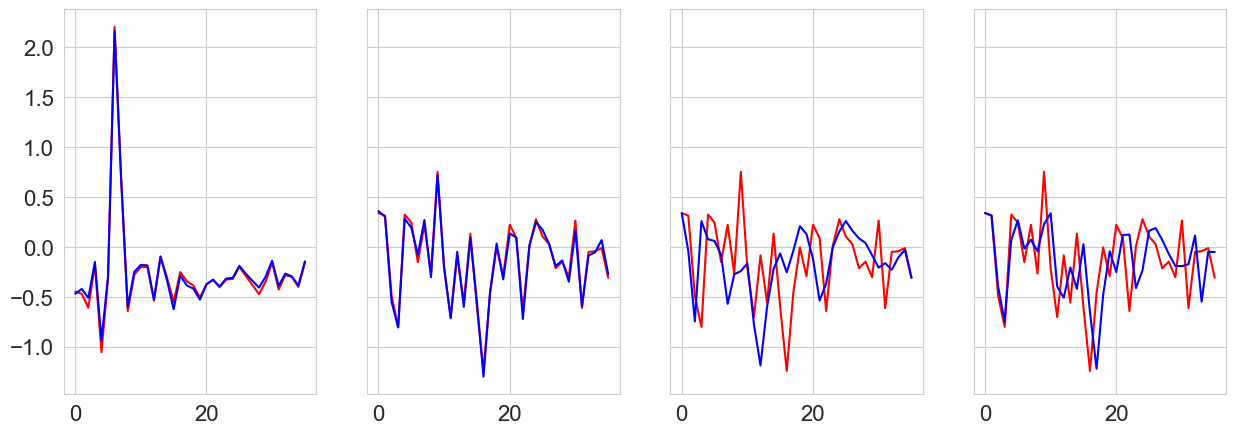

In [18]:
import utils.augmentation as aug
np.random.seed(98)
fig, ax = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

ax[0].plot(x_train[0, :, 0], color="red")
ax[0].plot(aug.magnitude_warp(x_train, sigma=0.1, knot=10)[0, :, 0], color="blue")

ax[1].plot(x_train[2, :, 0], color="red")
ax[1].plot(aug.jitter(x_train, sigma=0.05)[2, :, 0], color="blue")

ax[2].plot(x_train[2, :, 0], color="red")
ax[2].plot(aug.time_warp(x_train)[2, :, 0], color="blue")

ax[3].plot(x_train[2, :, 0], color="red")
ax[3].plot(aug.window_slice(x_train)[2, :, 0], color="blue")

plt.show()
x_train = np.append(x_train, aug.jitter(x_train, sigma=0.07)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000], axis=0)
x_train = np.append(x_train, aug.magnitude_warp(x_train, sigma=0.15, knot=10)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000], axis=0)
x_train = np.append(x_train, aug.time_warp(x_train)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000], axis=0)
x_train = np.append(x_train, aug.window_slice(x_train)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000], axis=0)

indexes = np.random.choice(x_train.shape[0], x_train.shape[0])
x_train = x_train[indexes]
y_train = y_train[indexes]

In [3]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [9]:
def Inception1D(filters, strides=1, padding="same"):
    """
    Builds an Inception module for 1D data with Conv1D.
    """

    def inception(x):
        # Define the branch structures
        branch1x1 = Conv1D(filters=filters, kernel_size=1, strides=strides, padding=padding)(x)
        branch1x1 = Activation("relu")(branch1x1)
        branch1x1 = BatchNormalization()(branch1x1)

        branch3x3 = Conv1D(filters=filters, kernel_size=1, strides=strides, padding=padding)(x)
        branch3x3 = Activation("relu")(branch3x3)
        branch3x3 = BatchNormalization()(branch3x3)
        branch3x3 = Conv1D(filters=filters, kernel_size=3, strides=strides, padding=padding)(branch3x3)
        branch3x3 = Activation("relu")(branch3x3)
        branch3x3 = BatchNormalization()(branch3x3)

        branch5x5 = Conv1D(filters=filters, kernel_size=1, strides=strides, padding=padding)(x)
        branch5x5 = Activation("relu")(branch5x5)
        branch5x5 = BatchNormalization()(branch5x5)
        branch5x5 = Conv1D(filters=filters, kernel_size=5, strides=strides, padding=padding)(branch5x5)
        branch5x5 = Activation("relu")(branch5x5)
        branch5x5 = BatchNormalization()(branch5x5)

        branchpool = MaxPooling1D(pool_size=3, strides=strides, padding=padding)(x)
        branchpool = Conv1D(filters=filters, kernel_size=1, strides=strides, padding=padding)(branchpool)
        branchpool = Activation("relu")(branchpool)
        branchpool = BatchNormalization()(branchpool)

        # Concatenate the branches
        x = concatenate([branch1x1, branch3x3, branch5x5, branchpool], axis=2)

        return x

    return inception

In [21]:


def build_GoogLeNet_model(inputShape, nClasses, learningRate=0.001, momentum=0.9, loss="categorical_crossentropy",
                        metrics=["accuracy"]):
    """
    Builds a GoogLeNet model for data series with Conv1D.
    """
    # Define the model input
    input = Input(shape=inputShape)

    # Apply convolutional layers
    x = Conv1D(filters=32, kernel_size=3, strides=1, padding="same")(input)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=3, strides=1, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=128, kernel_size=3, strides=1, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    # Apply Inception modules
    x = Inception1D(filters=64, strides=1, padding="same")(x)
    x = Inception1D(filters=128, strides=1, padding="same")(x)
    x = Inception1D(filters=256, strides=1, padding="same")(x)

    # Apply global pooling
    x = GlobalAveragePooling1D()(x)

    # Add a fully connected layer
    x = Dense(units=nClasses)(x)
    x = Activation("softmax")(x)

    # Define the model
    model = Model(inputs=input, outputs=x)

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=learningRate, momentum=momentum), loss=loss, metrics=metrics)

    return model


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_54 (Conv1D)             (None, 36, 32)       608         ['input_3[0][0]']                
                                                                                                  
 activation_56 (Activation)     (None, 36, 32)       0           ['conv1d_54[0][0]']              
                                                                                                  
 batch_normalization_54 (BatchN  (None, 36, 32)      128         ['activation_56[0][0]']          
 ormalization)                                                                              

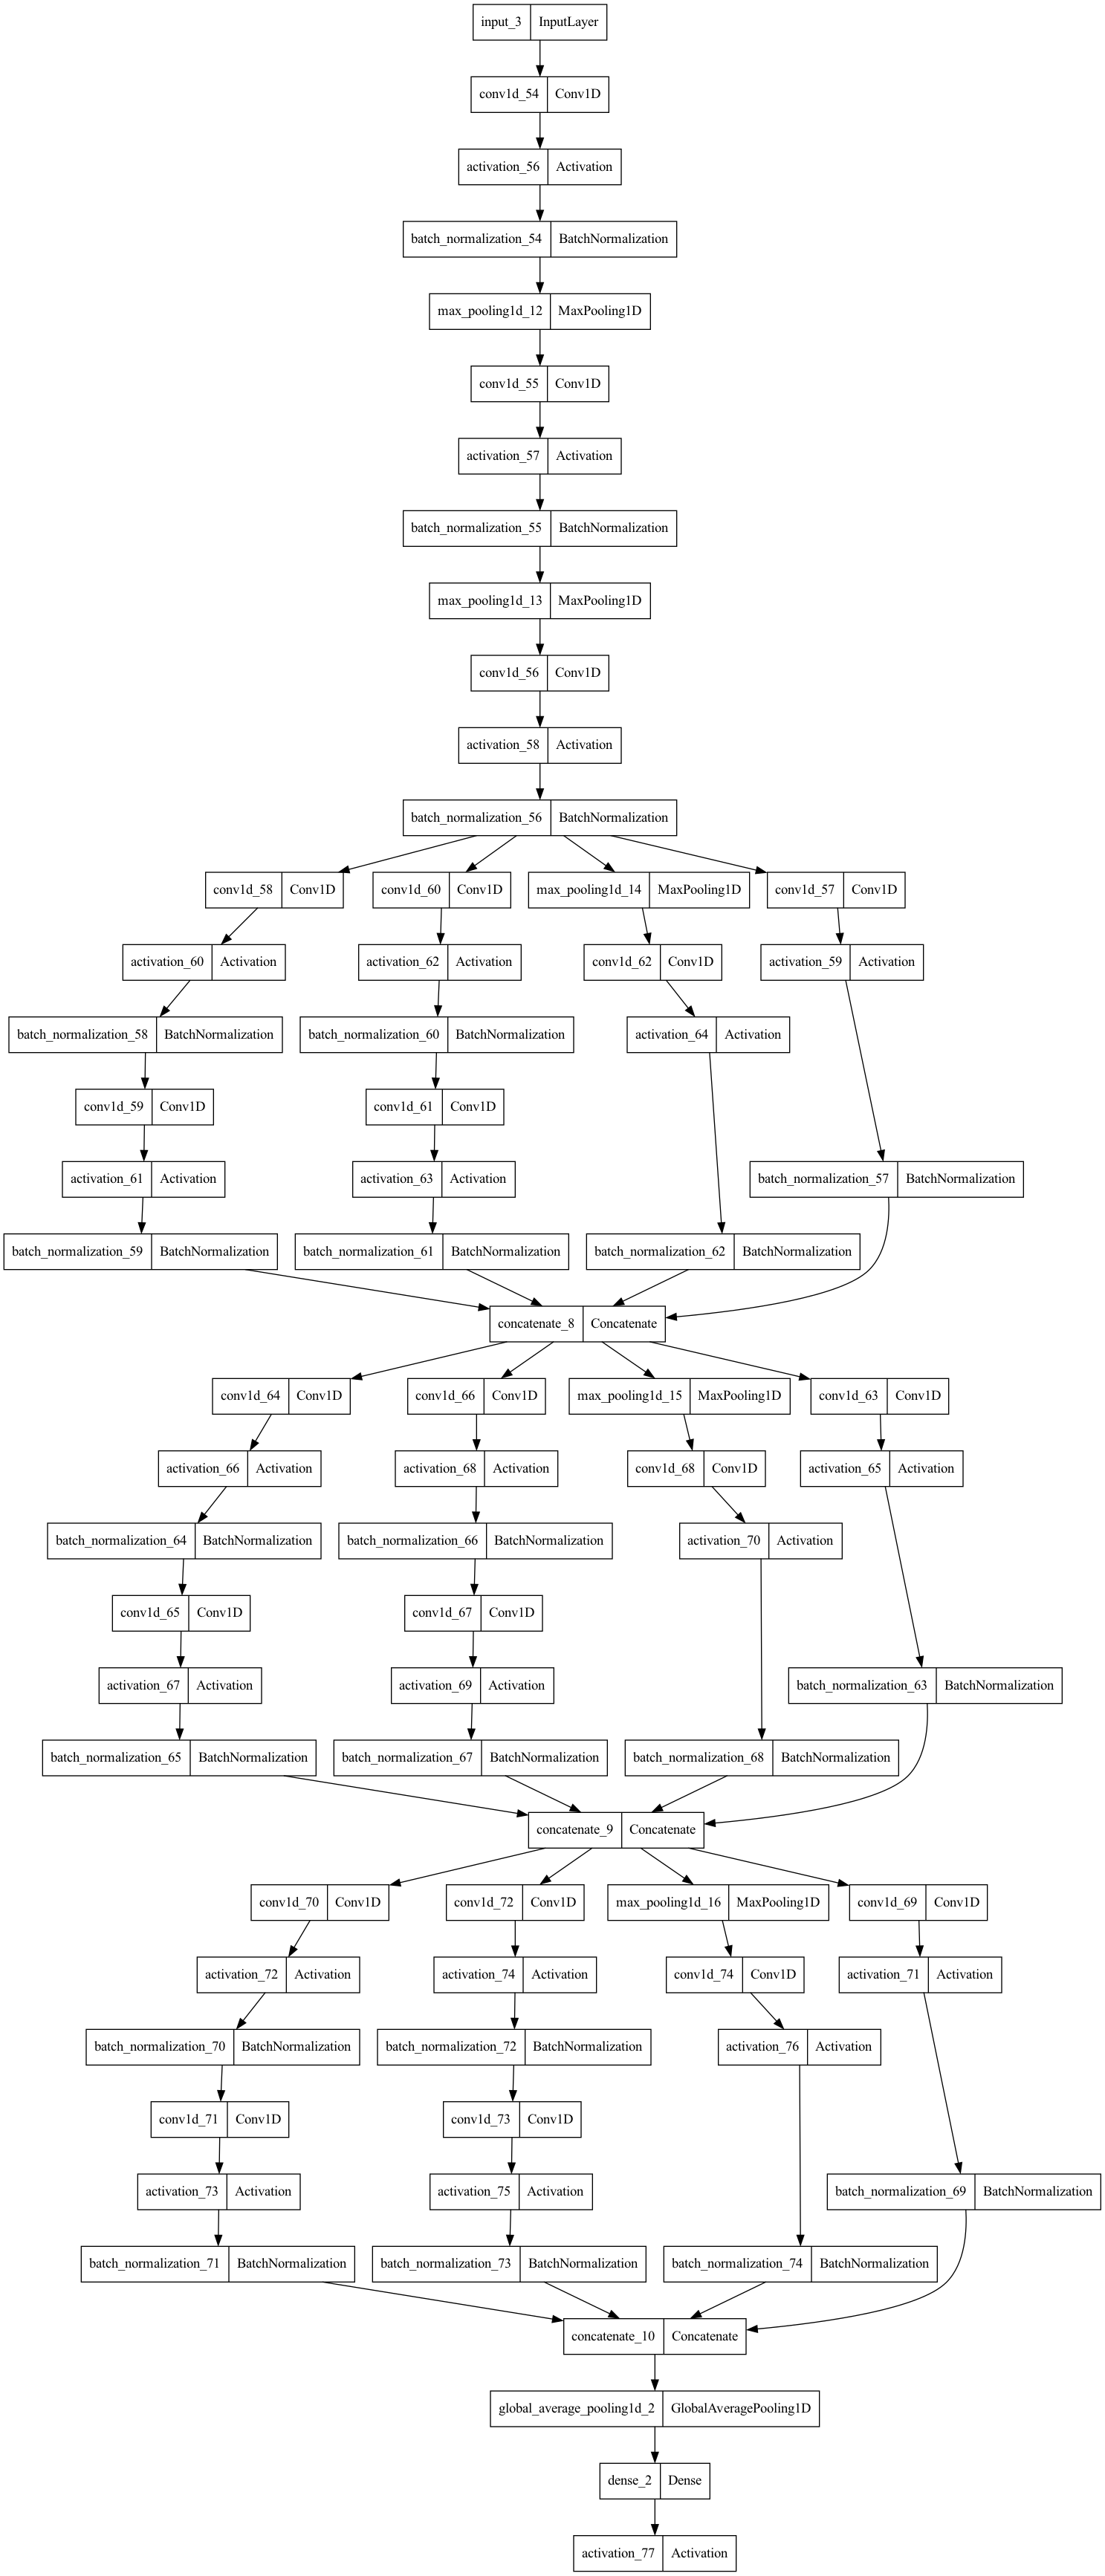

In [22]:
model = build_GoogLeNet_model(input_shape, classes)
model.summary()
tfk.utils.plot_model(model)

In [23]:
# Train the model
# model = tf.keras.models.load_model("GoogLeNet")

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-15 18:26:00.107021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - ETA: 0s - loss: 1.6644 - accuracy: 0.4871

2022-12-15 18:26:26.141920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - 33s 177ms/step - loss: 1.6644 - accuracy: 0.4871 - val_loss: 2.1137 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 10s 86ms/step - loss: 0.9013 - accuracy: 0.7409 - val_loss: 1.5955 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/200
118/118 [==============================] - 10s 86ms/step - loss: 0.6315 - accuracy: 0.8335 - val_loss: 1.1686 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 4/200
118/118 [==============================] - 10s 81ms/step - loss: 0.4724 - accuracy: 0.8901 - val_loss: 1.1124 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 5/200
118/118 [==============================] - 10s 81ms/step - loss: 0.3625 - accuracy: 0.9216 - val_loss: 1.1272 - val_accuracy: 0.7026 - lr: 0.0010
Epoch 6/200
118/118 [==============================] - 10s 82ms/step - loss: 0.2892 - accuracy: 0.9429 - val_loss: 1.1544 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 7/200
118/118 [==============================] - 10s 87ms

INFO:tensorflow:Assets written to: GoogLeNet/assets


INFO:tensorflow:Assets written to: GoogLeNet/assets


16/16 [==============================] - 0s 21ms/step
Accuracy: 0.6214
Precision: 0.6341
Recall: 0.4976
F1: 0.5294


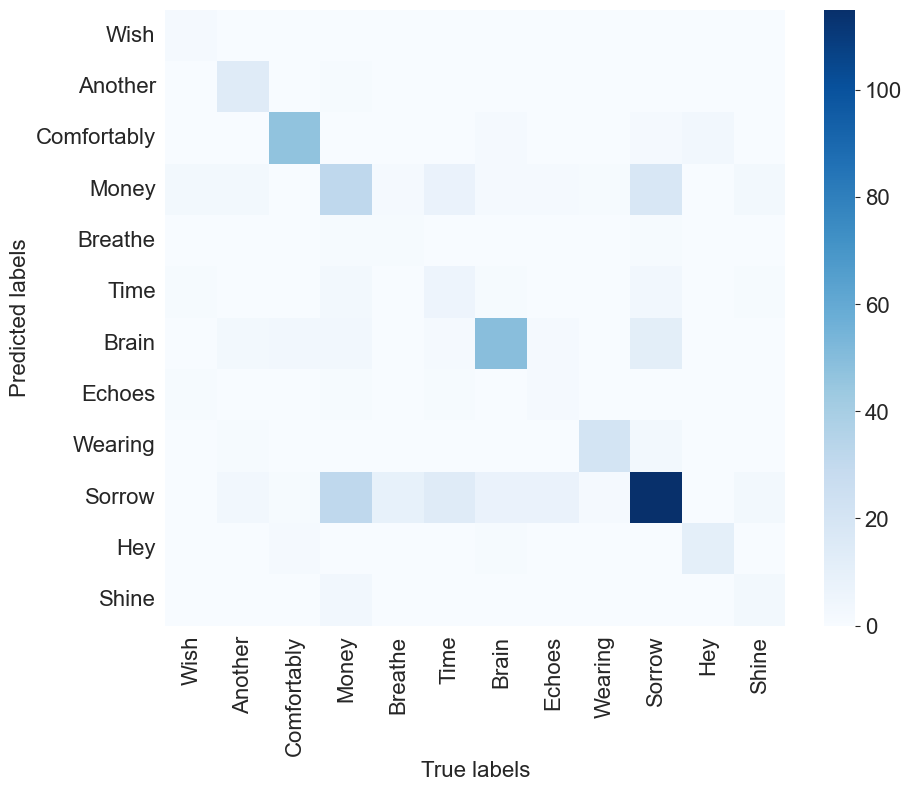

In [25]:
model.save('GoogLeNet')
# Predict the test set with the 1DCNN
predictions = model.predict(x_test)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()